In [1]:
# Payoff examples
#payoff_mats = [payoff_matrices.define_hawk_dove_retailator_payoff(v=0.7,c=1.0)] * 6

#payoff_mats = [payoff_matrices.define_hawk_dove_retailator_payoff(v=0.7,c=1.0),
#               payoff_matrices.define_hawk_dove_retailator_payoff(v=0.5,c=1.0),
#               payoff_matrices.define_hawk_dove_retailator_payoff(v=0.8,c=1.2),
#               payoff_matrices.define_hawk_dove_retailator_payoff(v=0.9,c=0.9),
#               payoff_matrices.define_hawk_dove_retailator_payoff(v=0.4,c=1.2),
#               payoff_matrices.define_hawk_dove_retailator_payoff(v=0.5,c=0.2)]

#payoff_mats = [payoff_matrices.define_evo_stable_set_payoff()]

#payoff_mats = [payoff_matrices.define_hawk_dove_payoff(v=0.7,c=1.0)]

In [2]:
# Adjacency matrix examples
# adj_mat = adajcency_matrices.get_id_matrix(num_nodes=num_nodes)
# adj_mat = create_block_matrix_unit_row_sum(num_nodes=6, num_blocks=2, prob_link=0.5, seed=7)
# adj_mat = adajcency_matrices.A2
# adj_mat = adajcency_matrices.A3

In [3]:
import torch
import pandas as pd

from graph import EGTGraph
import payoff_matrices
import adajcency_matrices
from gnn import GCN
from fitness import mean_squared_diff_fitness_graph, fit_strategy_node, fit_strategy_graph, get_nodes_strategy_fitness_df
from funs_examples import create_block_matrix_unit_row_sum
from utils import is_ess

Define payoffs

In [4]:
payoff_mats = [payoff_matrices.define_hawk_dove_payoff(v=0.7,c=1.0), payoff_matrices.define_hawk_dove_payoff(v=0.9,c=1.0)]
num_nodes = len(payoff_mats)

Define adjacency matrix

In [5]:
adj_mat = adajcency_matrices.A3

In [6]:
# Create graph 
g = EGTGraph(payoff_matrices = payoff_mats,adjacency_matrix=adj_mat, seed_nodes_features=3)

/Users/lrigolli/PycharmProjects/GNN/utils.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  x_tensor = torch.tensor(x_list, dtype=torch.float)


In [7]:
# import copy
# q: do we miss some ESS by removing dominated strategies?
# g = copy.deepcopy(g0)
# g0.describe_egtgraph()
# TODO: FIX Remove dominated strategies
#g.remove_dominated_strategies_iterative()
# Describe graph afteer removal of dominated strategies
# g.describe_egtgraph()

Num nodes: 2
Num strategies: 2
Num edges: 4
Adjacency matrix
[[{tensor([[0.5000, 0.5000],
          [0.5000, 0.5000]])}]]
Payoff matrices
Node 0
[[-0.15  0.7 ]
 [ 0.    0.35]]
Node 1
[[-0.05  0.9 ]
 [ 0.    0.45]]
Nodes features: [[0.43750727 0.5624927 ]
 [0.3628452  0.6371548 ]]
Nodes weights: [1. 1.]
Dominated strategies: []
Match between non-dominated reduced strategies and original strategies: None


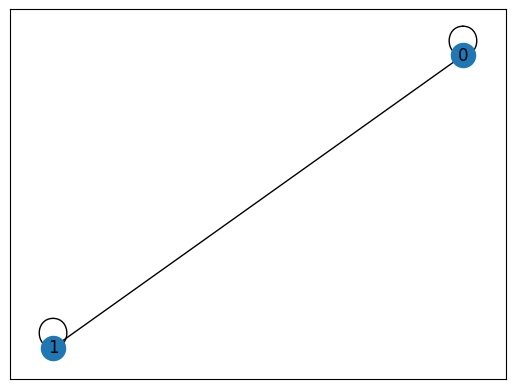

In [8]:
# Describe graph
g.describe_egtgraph()

In [9]:
# Define GNN model 
hid1_in = 10
hid2_in = 10
model = GCN(graph=g, payoff_matrices=g.payoff_matrices, hid1_in=hid1_in, hid2_in=hid2_in)

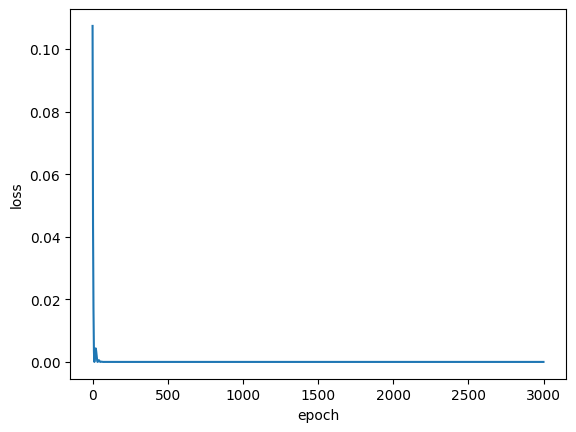

In [10]:
# Train model
num_epochs = 3000
pred, loss = model.optimize(num_epochs=num_epochs)

In [11]:
print(f"loss: {loss}")
if loss != 0:
    print("point is not ESS for all nodes, two strategies have different payoffs in at least one node")
else: 
    print("point satisfies necessary condition to be ESS for all nodes. further checks are needed to find it out")

loss: 0.0
point satisfies necessary condition to be ESS for all nodes. further checks are needed to find it out


In [12]:
# Show fitness of different strategies in different nodes
df_nodes_strategy_fit =  get_nodes_strategy_fitness_df(X=pred, graph=g, payoff_matrices=g.payoff_matrices)

In [13]:
df_nodes_strategy_fit

,strat_0,strat_1
node_0,0.08,0.08
node_1,0.08,0.08


In [14]:
# check if point p_i is ESS for node i 
# aggregated payoff matrix is componentwise multiplication of adj matrix and sum of payoffs
# payoff_aggr = adj_mat * (payoff_mats[0] + payoff_mats[1])

In [17]:
# Compute an updated payoff matrix for each node. Each payoff matrix comes from aggregation of other matrices in graph.
#  The aggregated payoff matrix for node k is given by P_agg[k] = \sum_{l=1}^n A[k,l] P[l] 
payoff_aggr_mats = []
for k in range(num_nodes):
    payoff_aggr = torch.zeros((g.num_feats,g.num_feats))
    for l in range(len(payoff_mats)):
        payoff_aggr += adj_mat[k, l] * g.payoff_matrices[l]
    payoff_aggr_mats.append(payoff_aggr)

# Check if each of the point in node is ESS. In case we have a global ESS for entire system
# (condition on payoff matrix is replaced by condition on aggregated payoff matrix)
for i in range(num_nodes):
    ess_point = is_ess(pred[i], payoff_aggr_mats[i])

gradient of p^T*F*y - y^T*F*y at point p: [0.]
Hessian of p^T*F*y - y^T*F*y at point p: [[0.99999994]]
[0.8        0.20000003] is a critical point
[0.8        0.20000003] is ESS
gradient of p^T*F*y - y^T*F*y at point p: [0.]
Hessian of p^T*F*y - y^T*F*y at point p: [[0.99999994]]
[0.8        0.20000003] is a critical point
[0.8        0.20000003] is ESS


/Users/lrigolli/PycharmProjects/GNN/utils.py:92: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  grad = torch.matmul(phi.T, (torch.matmul(p.T, F) - torch.matmul(F.T, p) - torch.matmul(F, p)).T)


In [20]:
df_nodes_strat_candidate_ess = pd.DataFrame(pred, index=[f"node_{i}" for i in range(g.num_nodes)],columns=[f"strat_{i}" for i in range(g.num_feats)] )

In [21]:
df_nodes_strat_candidate_ess

,strat_0,strat_1
node_0,0.8,0.2
node_1,0.8,0.2


In [ ]:
stop

In [ ]:
# rmk: if v>d for hawk-dove then best strategy is obtained for loss >0

In [ ]:
# Move tensor to GPU if available
print(torch.cuda.is_available())
if torch.cuda.is_available():
    tensor = tensor.to("cuda")